In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import solver2 as solver

# Example of a basic neural network model (unnecessary here)
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size        # Input size 
        self.num_hidden = len(hidden_sizes) # Number of hidden layers
        self.hidden_sizes = hidden_sizes    # Hidden layer sizes
        self.output_size = output_size      # Output size

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(activation_fn)
        for i in range(1, self.num_hidden):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(activation_fn)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        initialization_method = None
        if isinstance(activation_fn, nn.ReLU):
            initialization_method = 'kaiming'
        elif isinstance(activation_fn, (nn.Tanh, nn.Sigmoid)):
            initialization_method = 'xavier'
        self._initialize_weights(method=initialization_method)
        
    def _initialize_weights(self, method):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if method == 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight)
                elif method == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [1]:
# 2D PDE example
# partial_x f(x,y) + partial_y f(x,y) = 0, for (x,y) in [0,1]x[0,1]
# f(x, 0) = x^2, for x in [0,1]
# f(0, y) = y^2, for y in [0,1]
# Analytic solution: f(x, y) = (x - y)^2

def differential_2d(x, f):
    x = x.requires_grad_(True)
    fx = f(x)
    output_shape = torch.ones_like(fx) # shape (N,1) for N example points
    gradients = autograd.grad(fx, x, output_shape, create_graph=True)[0]
    Dx_fx = gradients[:, 0]
    Dy_fx = gradients[:, 1]
    return Dx_fx + Dy_fx

def boundary_x(xb, f):
    # f(x,0) = x^2
    xb = xb.clone().detach().requires_grad_(True)
    fx = f(xb)
    return fx - xb[:,0].unsqueeze(1)**2

def boundary_y(yb, f):
    # f(0,y) = y^2
    yb = yb.clone().detach().requires_grad_(True)
    fy = f(yb)
    return fy - yb[:,1].unsqueeze(1)**2

xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

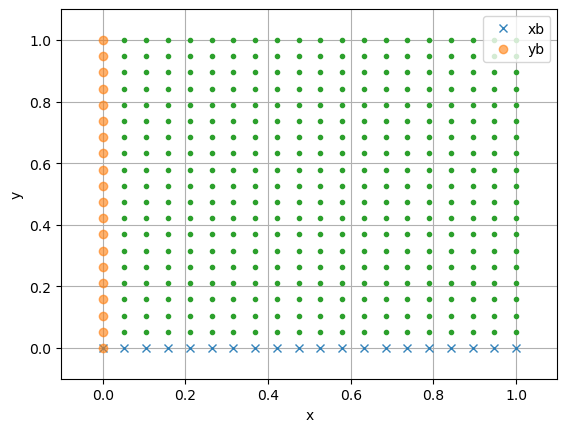

In [6]:
# Define training domain

num_points = 20 # Points per dimension
mesh_x, mesh_y = torch.meshgrid(torch.linspace(xmin, xmax, num_points), torch.linspace(ymin, ymax, num_points))
domain = torch.cat([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)], dim=1)

xb = domain[domain[:,1] == 0.0]
yb = domain[domain[:,0] == 0.0]
domain = domain[(domain[:,0] > 0.0+1e-5) & (domain[:,1] > 0.0+1e-5)] # 1e-5 tolerance of floating-point comparison

plt.plot(xb[:,0], xb[:,1], 'x', label='xb', alpha=0.9)
plt.plot(yb[:,0], yb[:,1], 'o', label='yb', alpha=0.6)
plt.plot(domain[:,0], domain[:,1], '.')
plt.xlim([xmin-0.1, xmax+0.1])
plt.ylim([ymin-0.1, ymax+0.1])
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Epoch 1/1000 Loss: 0.25111299753189087
Epoch 2/1000 Loss: 0.9538566470146179
Epoch 3/1000 Loss: 0.27662429213523865
Epoch 4/1000 Loss: 0.29506421089172363
Epoch 5/1000 Loss: 0.49011117219924927
Epoch 6/1000 Loss: 0.4165399372577667
Epoch 7/1000 Loss: 0.25115498900413513
Epoch 8/1000 Loss: 0.18250884115695953
Epoch 9/1000 Loss: 0.23263999819755554
Epoch 10/1000 Loss: 0.2969963252544403
Epoch 11/1000 Loss: 0.29283955693244934
Epoch 12/1000 Loss: 0.2382778376340866
Epoch 13/1000 Loss: 0.18759925663471222
Epoch 14/1000 Loss: 0.17213967442512512
Epoch 15/1000 Loss: 0.1882106363773346
Epoch 16/1000 Loss: 0.21214058995246887
Epoch 17/1000 Loss: 0.22130608558654785
Epoch 18/1000 Loss: 0.20906680822372437
Epoch 19/1000 Loss: 0.18550750613212585
Epoch 20/1000 Loss: 0.16647979617118835
Epoch 21/1000 Loss: 0.1613110601902008
Epoch 22/1000 Loss: 0.16781029105186462
Epoch 23/1000 Loss: 0.17658205330371857
Epoch 24/1000 Loss: 0.17921435832977295
Epoch 25/1000 Loss: 0.17324143648147583
Epoch 26/1000 L

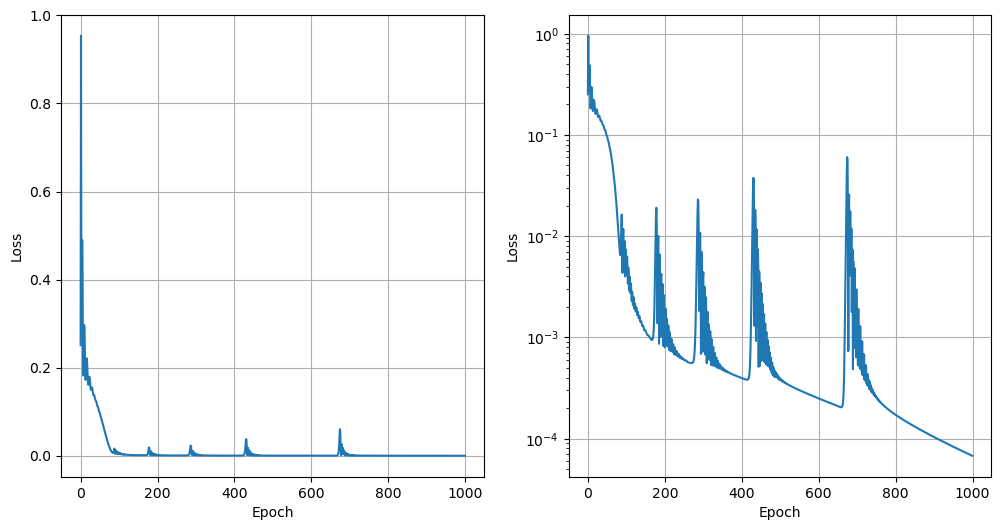

In [7]:
bc_tuples = [(boundary_x, xb), (boundary_y, yb)]
# bc_tuples = [(boundary_y, yb)]

loss_fn = solver.LossFunction(differential_2d, bc_tuples)

# model = NeuralNetwork(2, [200], 1, activation_fn=nn.Tanh())

model = nn.Sequential(
    nn.Linear(2, 200),
    nn.Tanh(),
    nn.Linear(200, 1000),
    nn.Tanh(),
    nn.Linear(1000, 200),
    nn.Tanh(),
    nn.Linear(200, 1)
)

epochs = 1000
lr = 0.0005
loss_data = solver.train(model, loss_fn, domain, epochs, lr, print_progress=True)
# loss_data = np.ones(epochs) # Quick dummy data

# -- Analysis --

# Loss plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(np.arange(epochs), loss_data)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[1].plot(np.arange(epochs), loss_data)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].grid(True)

plt.show()

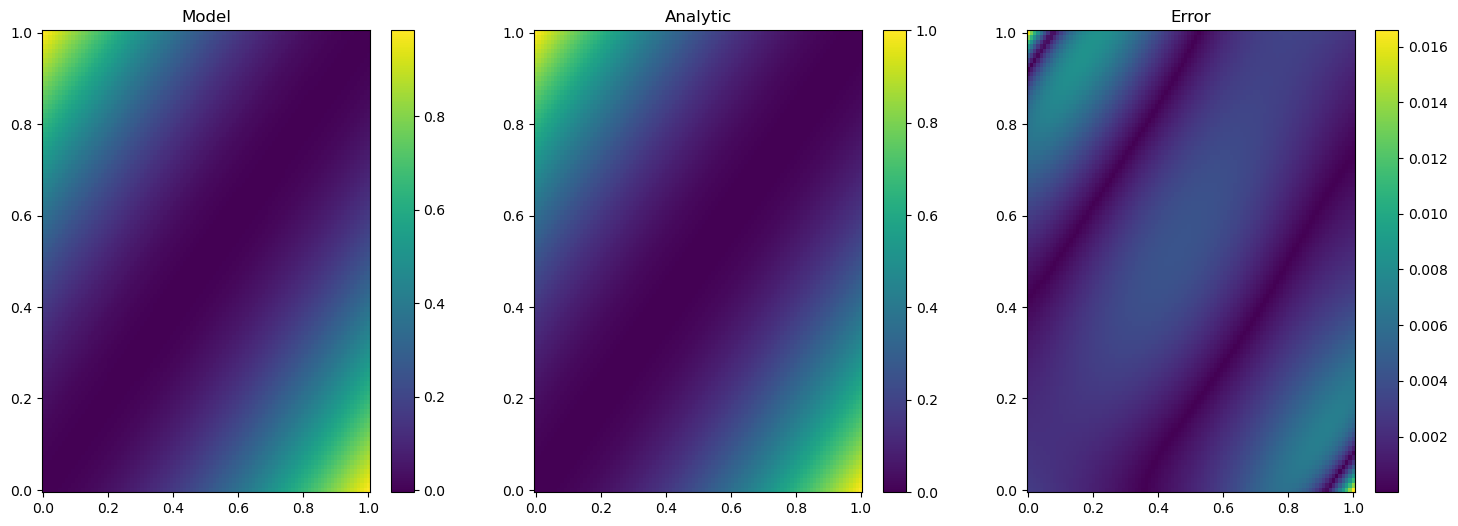

In [8]:
# Evaluation of the model

def analytic_solution(x):
    # f(x, y) = (x - y)^2
    return (x[:,0] - x[:,1])**2

num_eval_points = 100 # per dimension
eval_x, eval_y = torch.meshgrid(torch.linspace(xmin, xmax, num_eval_points), torch.linspace(ymin, ymax, num_eval_points))
eval_domain = torch.cat([eval_x.reshape(-1, 1), eval_y.reshape(-1, 1)], dim=1)

with torch.no_grad():
    eval_domain.requires_grad_(True)
    eval_f = model(eval_domain)
    eval_f = eval_f.reshape(num_eval_points, num_eval_points)
    eval_f = eval_f.numpy()
    eval_domain.requires_grad_(False)
    eval_domain = eval_domain.numpy()

eval_analytic = analytic_solution(eval_domain)
eval_analytic = eval_analytic.reshape(num_eval_points, num_eval_points)


# Plot results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
c = ax[0].pcolormesh(eval_x, eval_y, eval_f, shading='auto')
ax[0].set_title('Model')
fig.colorbar(c, ax=ax[0])
c = ax[1].pcolormesh(eval_x, eval_y, eval_analytic, shading='auto')
ax[1].set_title('Analytic')
fig.colorbar(c, ax=ax[1])
c = ax[2].pcolormesh(eval_x, eval_y, np.abs(eval_f - eval_analytic), shading='auto')
ax[2].set_title('Error')
fig.colorbar(c, ax=ax[2])
plt.show()
